# Model Evaluation for Nuclei Dataset

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from helper_functions import display_images, normalize, create_mask, calculate_metrics

## Load Data

In [2]:
# run with saved data on subsequent runs
data = np.load("data/nuclei_data.npz")
images = data["images"]/1.0
masks = np.expand_dims(data["masks"], axis=-1)/1.0
types = data['types']
images, masks, types = shuffle(images, masks, types, random_state=12)

# train/val/test split
train_split = round(len(images) * 0.7)
val_split = round(len(images) * 0.2) + train_split

images_train = images[:train_split]
images_val = images[train_split:val_split]
images_test = images[val_split:]

masks_train = masks[:train_split]
masks_val = masks[train_split:val_split]
masks_test = masks[val_split:]

types_train = types[:train_split]
types_val = types[train_split:val_split]
types_test = types[val_split:]

In [3]:
print("Train masks:", masks_train.shape)
print("Validation masks:", masks_val.shape)
print("Test masks:", masks_test.shape)

Train masks: (4268, 256, 256, 1)
Validation masks: (1219, 256, 256, 1)
Test masks: (610, 256, 256, 1)


In [4]:
# The tf.data pipeline needs to be established in order to input the image and true masks into the model. 
train_set = tf.data.Dataset.from_tensor_slices((images_train, masks_train))
train_set = train_set.map(normalize)
train_set = train_set.batch(1)

valid_set = tf.data.Dataset.from_tensor_slices((images_val, masks_val))
valid_set = valid_set.map(normalize)
valid_set = valid_set.batch(1)

test_set = tf.data.Dataset.from_tensor_slices((images_test, masks_test))
test_set = test_set.map(normalize)
test_set = test_set.batch(1)

## Load Model

In [5]:
unet = tf.keras.models.load_model("model/best_model")

In [6]:
history = np.load("model/best_model_train_history.npy", allow_pickle=True).item(0)

## Evaluation

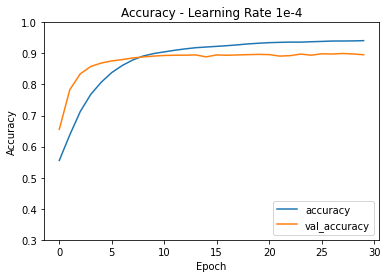

In [7]:
# plot model accuracy
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.title('Accuracy - Learning Rate 1e-4')

plt.show()

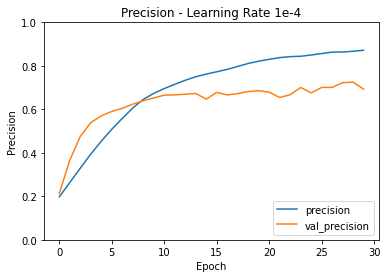

In [8]:
# plot model precision
plt.plot(history['precision'], label='precision')
plt.plot(history['val_precision'], label = 'val_precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')
plt.title('Precision - Learning Rate 1e-4')

plt.show()

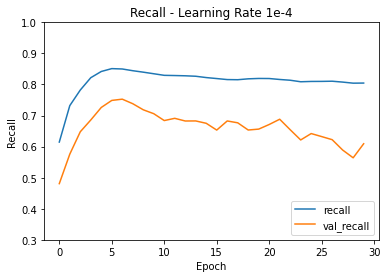

In [9]:
# plot model recall
plt.plot(history['recall'], label='recall')
plt.plot(history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.title('Recall - Learning Rate 1e-4')

plt.show()

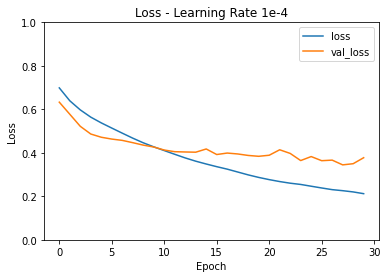

In [10]:
# plot model loss
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Loss - Learning Rate 1e-4')

plt.show()

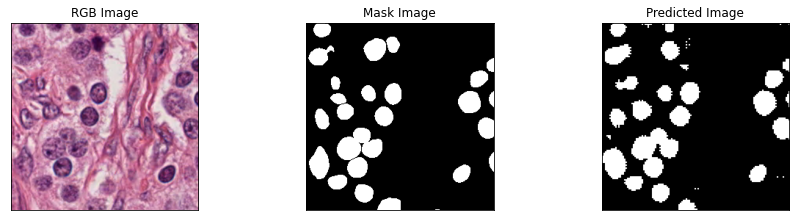

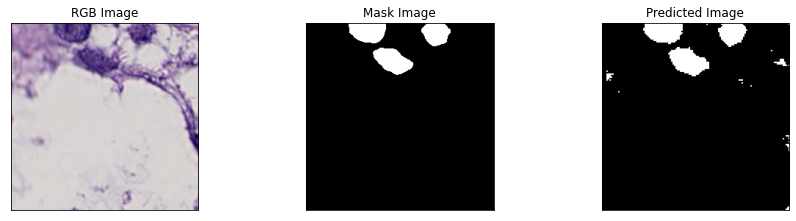

In [11]:
# predict and visualize first train image
i = 0
IMG_SIZE = (128, 128)

for image, mask in train_set.take(2):
    pred_mask = unet.predict(image)
    display_images(images_train[i], np.squeeze(masks_train[i]), create_mask(pred_mask, IMG_SIZE))
    i+=1

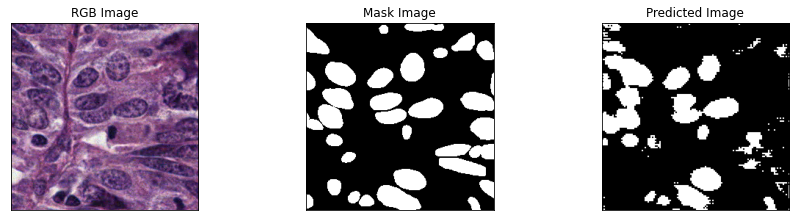

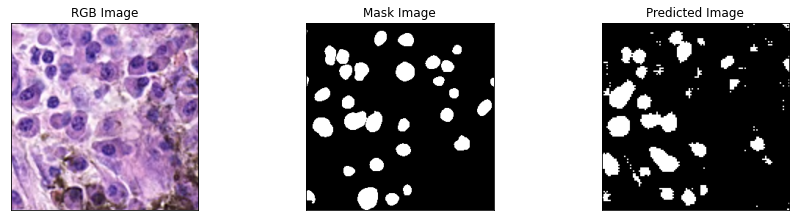

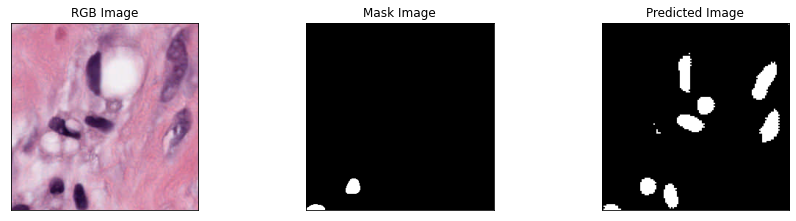

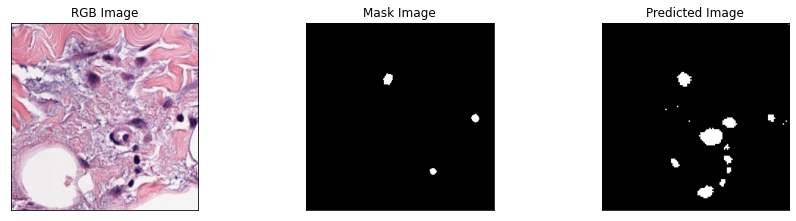

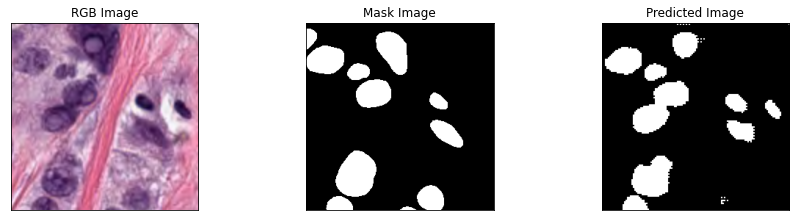

In [12]:
# predict masks for test images
i=0
for image, mask in test_set.take(5):
    pred_mask = unet.predict(image)
    display_images(images_test[i], np.squeeze(masks_test[i]), create_mask(pred_mask, IMG_SIZE))
    i+=1

In [13]:
# train metrics:
train_results = unet.evaluate(train_set)

4268/4268 [==============================] - 552s 120ms/step - loss: 0.2095 - precision: 0.8769 - recall: 0.7863 - accuracy: 0.9404


In [14]:
# validation metrics:
val_acc, val_prec, val_recall, val_iou = calculate_metrics(unet, valid_set, IMG_SIZE)

print('Validation Metrics:')
print('Accuracy =', round(val_acc,4))
print('Precision =', round(val_prec,4))
print('Recall =', round(val_recall,4))
print('Mean IoU =', round(val_iou,4))
print()

# test metrics:
test_acc, test_prec, test_recall, test_iou = calculate_metrics(unet, test_set, IMG_SIZE)

print('Test Metrics:')
print('Accuracy =', round(test_acc,4))
print('Precision =', round(test_prec,4))
print('Recall =', round(test_recall,4))
print('Mean IoU =', round(test_iou,4))

Validation Metrics:
Accuracy = 0.8957
Precision = 0.6929
Recall = 0.61
Mean IoU = 0.6908

Test Metrics:
Accuracy = 0.8927
Precision = 0.6932
Recall = 0.6037
Mean IoU = 0.687
